# Can Language Models Solve Olympiad Programming?

In this tutorial, you will build a Computing Olympiad agent that leverages two complementary techniques to boost performance: **retrieval** and **reflection**.


The code and data are all adapted from the paper "Can Language Models Solve Olympiad Programming?" by Quan Shi, Michael Tang, Karthik Narasimhan, and Shunyu Yao.

[![arXiv](http://img.shields.io/badge/cs.CL-arXiv%3A2404.10952v1-B31B1B.svg)](https://arxiv.org/abs/2404.10952v1)
[![GitHub stars](https://img.shields.io/github/stars/princeton-nlp/USACO.svg?style=social&label=Stars)](https://github.com/princeton-nlp/USACO)

The memory overview is as follows:

![memory_retrieval](img/usaco-memory.png)


TODO: Excalidaraw diagram.

## Setup

First, install the requirements.

In [ ]:
# %pip install -U langgraph langsmith langchain_anthropic datasets

In [1]:
import getpass
import os


def _get_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_get_env("ANTHROPIC_API_KEY")
# Recommended
_get_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

LANGCHAIN_API_KEY:  ········


## Data

Fetch the USACO benchmark data using the util below:

In [2]:
import os
import zipfile

import datasets
import requests

usaco_url = "https://storage.googleapis.com/benchmarks-artifacts/usaco/usaco_sampled_with_tests.zip"
zip_path = "usaco.zip"
extract_path = "usaco_datasets"

response = requests.get(usaco_url)
with open(zip_path, "wb") as file:
    file.write(response.content)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

os.remove(zip_path)

ds = datasets.load_from_disk(os.path.join(extract_path, "usaco_v3_sampled_with_tests"))

#### Test Evaluation Utils

We also need a way to evaluate our generated code. We will use this unsafe code execution program to run the generated code against our test cases.
**Note:** The code below runs arbitrary code on your local machine! Proceed with caution.

In [ ]:
import multiprocessing
import queue
import subprocess
import sys
import time
import traceback

multiprocessing.set_start_method("fork", force=True)
# WARNING
# This program exists to execute untrusted model-generated code. Although
# it is highly unlikely that model-generated code will do something overtly
# malicious in response to this test suite, model-generated code may act
# destructively due to a lack of model capability or alignment.
# Users are strongly encouraged to sandbox this evaluation suite so that it
# does not perform destructive actions on their host or network.
# Proceed at your own risk:


def exec_program(q, program, input_data, expected_output, timeout):
    try:
        start_time = time.time()
        process = subprocess.Popen(
            [sys.executable, "-c", program],
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
        )
        stdout, stderr = process.communicate(input=input_data, timeout=timeout)
        if time.time() - start_time > timeout:
            raise TimeoutError("Execution timed out.")
        if process.returncode != 0:
            q.put(f"failed: {stderr}")
        else:
            if stdout.strip() == expected_output.strip():
                q.put("passed")
            else:
                q.put(f"wrong answer. Expected '{expected_output}', got '{stdout}'")
    except subprocess.TimeoutExpired:
        process.kill()
        q.put("timed out")
    except Exception as e:
        q.put(f"failed: {traceback.format_exc()}")


def check_correctness(
    program: str, input_data: str, expected_output: str, timeout: float
) -> str:
    q = multiprocessing.Queue()
    process = multiprocessing.Process(
        target=exec_program, args=(q, program, input_data, expected_output, timeout)
    )
    process.start()
    process.join(timeout=timeout + 1)
    if process.is_alive():
        process.terminate()
        process.join()
        result = "timed out"
    else:
        try:
            result = q.get_nowait()
        except queue.Empty:
            result = "no result returned"
    return result

## Part 1: Zero-Shot

In our first section, we will build a simple zero-shot tool-calling agent to try to solve these problems. While simple, 

TODO: Add graph here.


### State

In [5]:
from typing import Annotated, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class TestCase(TypedDict):
    inputs: str
    outputs: str


class State(TypedDict):
    # Append-only chat memory
    messages: Annotated[list[AnyMessage], add_messages]
    # From the dataset
    test_cases: list[TestCase]
    runtime_limit: int
    status: str

Now, convert the dataset into inputs our graph will accept.

In [6]:
input_states = [
    {
        "messages": [("user", row["description"])],
        "test_cases": row["test_cases"],
        "runtime_limit": row["runtime_limit"],
        "status": "in_progress",
    }
    for row in ds
]

## Solver

In [7]:
from langchain_core.language_models import BaseChatModel
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


class writePython(BaseModel):
    """Write python code that resolves the problem."""

    reasoning: str = Field(..., description="Conceptual solution.")
    pseudocode: str = Field(..., description="Detailed English pseudocode.")
    code: str = Field(..., description="Valid Python 3 solution to the problem")


class Solver:
    def __init__(self, llm: BaseChatModel, prompt: ChatPromptTemplate):
        self.runnable = prompt | llm.bind_tools([writePython])

    def __call__(self, state: State) -> dict:
        # Our agent only can see the "messages" and will ignore the test info
        return {"messages": [self.runnable.invoke({"messages": state["messages"]})]}

In [34]:
from langchain import hub
from langchain_anthropic import ChatAnthropic

# For this section, we are testing zero-shot performance and won't have
# any examples
prompt = hub.pull("wfh/usaco-draft-solver").partial(examples="")
print("*" * 35 + "Prompt" + "*" * 35)
prompt.pretty_print()

# Use Haiku if you want to save $$
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm = ChatAnthropic(model="claude-3-opus-20240229")

solver = Solver(llm, prompt)

***********************************Prompt***********************************
================================ System Message ================================

You are a world-class competitive programmer.
Please reply with a Python 3 solution to the problem below. 
First, reason through the problem and conceptualize a solution.
Then write detailed pseudocode to uncover any potential logical errors or omissions.
Finally output the working Python code for your solution, ensuring to fix any errors uncovered while writing pseudocode.

No outside libraries are allowed.

============================= Messages Placeholder =============================

{messages}


In [9]:
print("*" * 35 + "Example" + "*" * 35)
result = solver(
    {
        "messages": [
            (
                "user",
                "How do I get a perfectly random sample from an infinite stream",
            )
        ]
    }
)
result["messages"][0].pretty_print()
# Could expand to include (1)
# 1. Restate the problem in plain English
# 2. Closely following the explanation, restate and explain the solution in plain English
# 3. Write a pseudocode solution
# 4. Output the final Python solution with your solution steps in comments.

***********************************Example***********************************
================================== Ai Message ==================================

[{'id': 'toolu_01TFKNYCUNE8Kpw8EbxDq4HN', 'input': {'reasoning': 'To get a perfectly random sample from an infinite stream, we can use the "reservoir sampling" algorithm. This algorithm allows us to maintain a fixed-size sample of the stream, where each item in the stream has an equal probability of being in the sample.\n\nThe key idea is to maintain a reservoir of size k, and as we process each item from the stream, we randomly decide whether to include it in the reservoir or not. This ensures that the reservoir always contains a random sample of the last k items seen.', 'pseudocode': '1. Initialize an empty reservoir of size k.\n2. For each item in the infinite stream:\n   a. Generate a random number between 0 and the current index of the stream (inclusive).\n   b. If the random number is less than k, replace a random item in 

## Run Tests

In [11]:
program_code = "print('hello, world!')"
input_data = ""
expected_output = "hello, world!"
timeout = 2

test_result = check_correctness(program_code, input_data, expected_output, timeout)
print(test_result)

passed


Now define the evaluate node.

In [31]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage


# This is the node we will add to the graph
def format_tool_message(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response + "\nMake all fixes using the writePython tool.",
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def evaluate(state: State):
    test_cases = state["test_cases"]
    runtime_limit = state["runtime_limit"]
    ai_message: AIMessage = state["messages"][-1]
    if not ai_message.tool_calls:
        return {
            "messages": [
                HumanMessage(
                    content="No code submitted. Please try again using the correct python code."
                )
            ]
        }
    try:
        code = ai_message.tool_calls[0]["args"]["code"]
    except Exception as e:
        return {"messages": [format_tool_message(repr(e), ai_message)]}
    num_test_cases = len(test_cases)
    succeeded = 0
    test_results = []
    # TODO: Multiprocess
    for test_case in test_cases:
        input_data = test_case["inputs"]
        expected_output = test_case["outputs"]
        test_result = check_correctness(code, input_data, expected_output, timeout)
        test_results.append(test_result)
        if test_result == "passed":
            succeeded += 1
    pass_rate = succeeded / num_test_cases if num_test_cases else "N/A"
    if pass_rate == 1:
        return {"status": "success"}

    responses = "\n".join(
        [f"<test id={i}>\n{r}\n</test>" for i, r in enumerate(test_results)]
    )
    response = f"Incorrect submission. Please respond with updated code.\nPass rate: {succeeded}/{num_test_cases}\nResults:\n{responses}"
    formatted_message = format_tool_message(response, ai_message)
    return {"messages": [formatted_message]}

In [32]:
from langgraph.graph import END, StateGraph

builder = StateGraph(State)
builder.add_node("solver", solver)
builder.set_entry_point("solver")
builder.add_node("evaluate", evaluate)
builder.add_edge("solver", "evaluate")


def control_edge(state: State):
    if state.get("status") == "success":
        return END
    return "solver"


builder.add_conditional_edges("evaluate", control_edge, {END: END, "solver": "solver"})
graph = builder.compile()

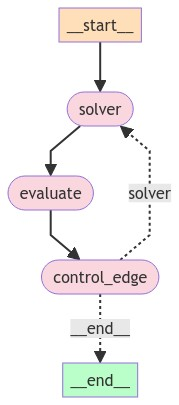

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

Now, run the graph.

In [43]:
input_state = input_states[0].copy()
# We will reduce the test cases to speed this notebook up
input_state["test_cases"] = input_state["test_cases"][:3]
print(input_state["messages"][0][1])


Farmer John has $N$ ($1 \leq N \leq 2 \cdot 10^5$) farms, numbered from $1$ to
$N$. It is known that FJ closes farm $i$ at time $c_i$. Bessie wakes up at time
$S$, and wants to maximize the productivity of her day by visiting as many farms
as possible before they close. She plans to visit farm $i$ on time $t_i + S$.
Bessie must arrive at a farm strictly before Farmer John closes it to actually visit it.

Bessie has $Q$ $(1 \leq Q \leq 2 \cdot 10^5)$ queries. For each query, she gives
you two integers $S$ and $V$. For each query, output whether Bessie can visit at
least $V$ farms if she wakes up at time $S$.

INPUT FORMAT (input arrives from the terminal / stdin):
The first line consists of $N$ and $Q$.

The second line consists of $c_1, c_2, c_3 \dots c_N$ ($1 \leq c_i \leq 10^6$).

The third line consists of $t_1, t_2, t_3 \dots t_N$ ($1 \leq t_i \leq 10^6$).

The next $Q$ lines each consist of two integers $V$ ($1 \leq V \leq N$) and $S$
($1 \leq S \leq 10^6$).

OUTPUT FORMAT (print

In [44]:
from langchain_core.messages import BaseMessage
from langchain_core.tracers.context import tracing_v2_enabled
from langsmith import Client


def _hide_test_cases(inputs):
    copied = inputs.copy()
    # These are tens of MB in size. No need to send them up
    copied["test_cases"] = f"..."
    return copied


client = Client(hide_inputs=_hide_test_cases, hide_outputs=_hide_test_cases)

with tracing_v2_enabled(client=client):
    events = graph.stream(input_state)
    for event in events:
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print(
                    "Assistant:",
                    str(value["messages"][-1].content).replace("\n", "\\n")[:50],
                )

Assistant: [{'id': 'toolu_019kK9iknYDZYcjtHamdvpHA', 'input':
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'id': 'toolu_01RePam9CkQ2AaDcUPGmy3Dy', 'input':
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'id': 'toolu_012EgNzVV6H358kMSQ8EnSKY', 'input':
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'text': '<result>\nHere is the Python 3 solution
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'id': 'toolu_01GVfnJ1tiuWJh3itwsBop93', 'input':
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'id': 'toolu_01ReaBtkLyZqSLyvU5tAgs8g', 'input':
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'text': '<result>\nHere is the Python 3 solution
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'id': 'toolu_0134AsW3tnszRT4onJ6wik7H', 'input':
Assistant: Incorrect submission. Please respond with updated 
Assistan

GraphRecursionError: Recursion limit of 25 reachedwithout hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

It wasn't able to solve it in time! These problems must be hard! In the next section we will add an improvement: "episodic memory".

## Part 2: Episodic Memory

What the authors call episodic memory is really few-shot prompting over similar examples using the correct answers. Lets add this below.

In [46]:
%pip install --upgrade --quiet  rank_bm25
from langchain_community.retrievers import BM25Retriever


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### State

In [133]:
from typing import Annotated, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class TestCase(TypedDict):
    inputs: str
    outputs: str


class State(TypedDict):
    # Append-only chat memory
    messages: Annotated[list[AnyMessage], add_messages]
    candidate: AIMessage
    # From the dataset
    test_cases: list[TestCase]
    runtime_limit: int
    examples: str
    status: str

In [134]:
from langchain import hub
from langchain_anthropic import ChatAnthropic


class Solver:
    def __init__(self, llm: BaseChatModel, prompt: ChatPromptTemplate):
        self.runnable = prompt | llm.bind_tools([writePython])

    def __call__(self, state: State) -> dict:
        # Our agent only can see the "messages" and will ignore the test info
        inputs = {"messages": state["messages"]}
        has_examples = bool(state.get("examples"))
        if has_examples:
            # Used in the solve node
            inputs["examples"] = state["examples"]
            return {"messages": [self.runnable.invoke(inputs)]}
        # Used in the draft node
        return {"candidate": self.runnable.invoke(inputs)}


prompt = hub.pull("wfh/usaco-draft-solver")
llm = ChatAnthropic(model="claude-3-opus-20240229")

draft_solver = Solver(llm, prompt.partial(examples=""))
solver = Solver(llm, prompt)

#### Retrieve

The retrieve node takes a candidate solution (made by the 'solver' node), uses _this_ to search for similar examples, then formats those in the message.

In [135]:
def format_example(row):
    question = row["description"]
    answer = row["solution"]
    return f"""<problem>
{question}
</problem>
<solution>
{answer}
</solution>"""


# Skip index 1 so we don't include the actual solution in our prompt.
# This is "simulating" having seen other in-context examples
retriever = BM25Retriever.from_texts([format_example(row) for row in list(ds)[1:]])

Now build the node.

In [148]:
from langchain_core.runnables import RunnableConfig


def retrieve_examples(state: State, config: RunnableConfig):
    top_k = config["configurable"].get("k") or 2
    ai_message: AIMessage = state["candidate"]
    if not ai_message.tool_calls:
        # We err here. To make more robust, you could loop back
        raise ValueError("Draft agent did not produce a valid code block")
    code = ai_message.tool_calls[0]["args"]["code"]
    examples_str = "\n".join(
        [doc.page_content for doc in retriever.invoke(code)[:top_k]]
    )
    examples_str = f"""
You previously solved the following problems in this competition:
<Examples>
{examples_str}
<Examples>
Approach this new question with similar sophistication."""
    return {"examples": examples_str}

#### Graph

In [144]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph

builder = StateGraph(State)
builder.add_node("draft", draft_solver)
builder.set_entry_point("draft")
builder.add_node("retrieve", retrieve_examples)
builder.add_node("solve", solver)
builder.add_node("evaluate", evaluate)
# Add connectivity
builder.add_edge("draft", "retrieve")
builder.add_edge("retrieve", "solve")
builder.add_edge("solve", "evaluate")


def control_edge(state: State):
    if state.get("status") == "success":
        return END
    return "solve"


builder.add_conditional_edges("evaluate", control_edge, {END: END, "solve": "solve"})


checkpointer = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=checkpointer)

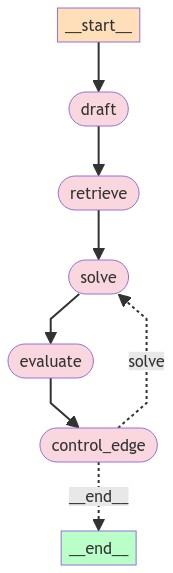

In [145]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

Let's try again:

In [ ]:
config = {"configurable": {"thread_id": "question-1", "k": 2}}
with tracing_v2_enabled(client=client):
    events = graph.stream(input_state, config)
    for event in events:
        for value in event.values():
            messages = value.get("messages")
            if messages:
                print(
                    "Assistant:",
                    str(value["messages"][-1].content).replace("\n", "\\n")[:50],
                )
            elif value.get("examples"):
                print("Retrieved examples:\n\n", value["examples"][:100] + "...")
            elif value.get("candidate"):
                print(str(value["candidate"].content)[:200])

[{'text': '<thinking>\nTo solve this problem, we need to implement a function that takes in the parameters N, Q, c_i, t_i, and a list of (V, S) query pairs, and returns a list of YES/NO answers for ea
Retrieved examples:

 
You previously solved the following problems in this competition:
<Examples>
<problem>

Farmer John...
Assistant: [{'text': '<thinking>\n\nTo determine if Bessie ca
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'id': 'toolu_01DmeWQn8LnVz3ddQPu5F4Rv', 'input':
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'id': 'toolu_01EvAPK2x2uEt1p2XZ3Bx9Zd', 'input':
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'id': 'toolu_01EokM4dztN6vAaRTVY2xGRF', 'input':
Assistant: Incorrect submission. Please respond with updated 
Assistant: [{'id': 'toolu_01VrJ8PEvaHFSx8FLmhp7dFw', 'input':
Assistant: Incorrect submission. Please respond with updated 
Assistant: <result>\nHere is the fixed Python code th

No timeout error! Let's check the graph state to confirm.

In [ ]:
checkpoint = graph.get_state(config)
checkpoint.values["status"]

## Part 3: Reflection

TODO.